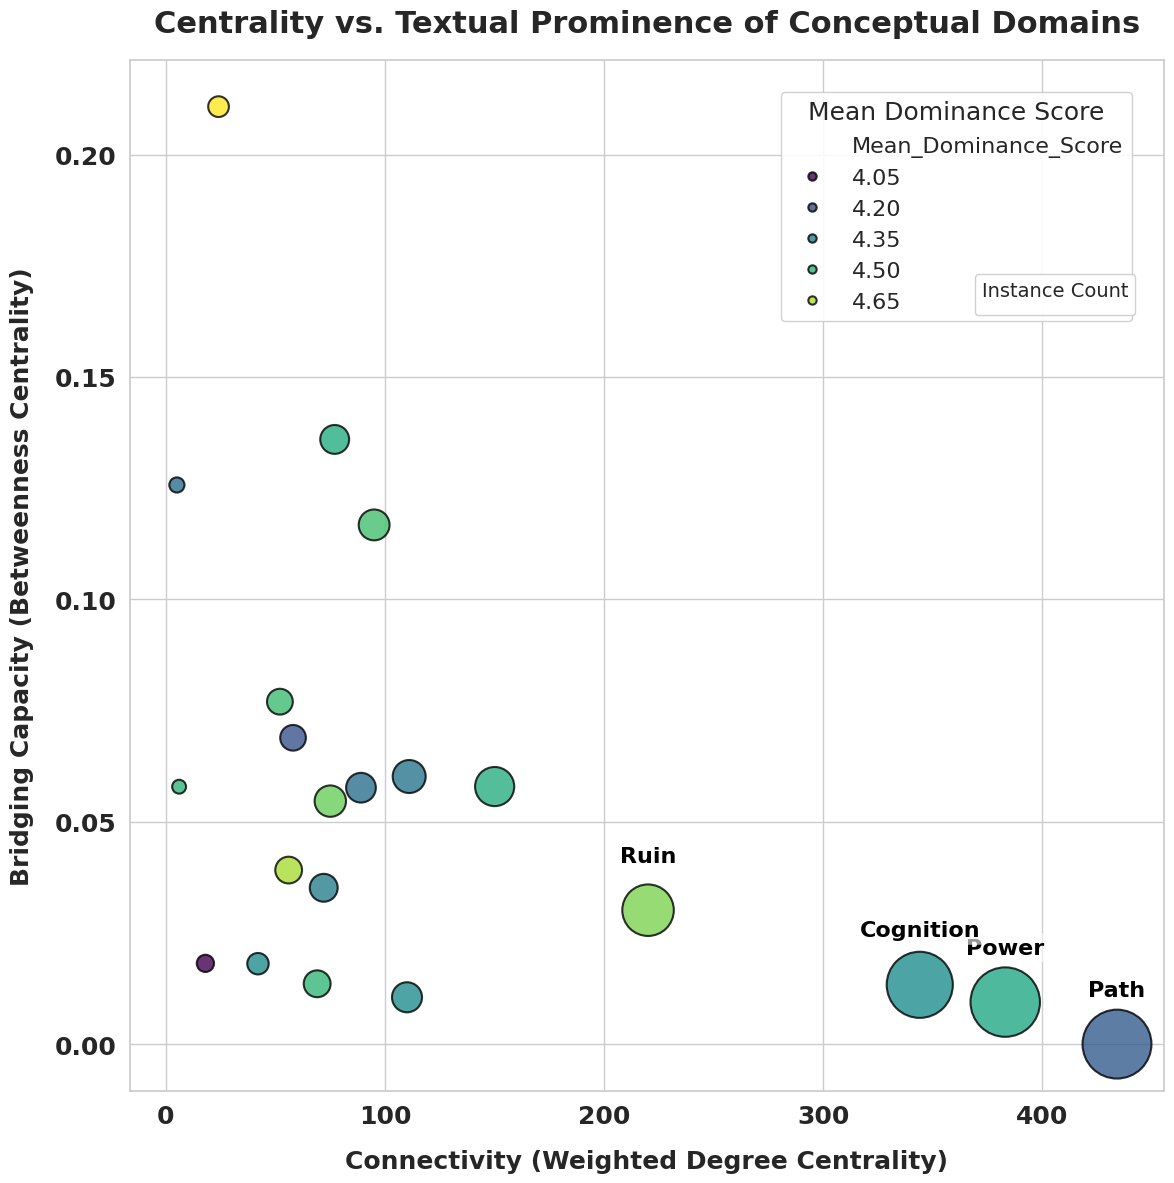

In [2]:
#@title  **Centrality vs. Textual Prominence of Conceptual Domains**

# --- [الخطوة 0: التثبيت والاستيراد] ---
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations

# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
print("--- [Step 1: Loading Data] ---")
# ⚠️⚠️⚠️  الرجاء التأكد من أن هذا المسار صحيح في بيئتك
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()



# --- 2. بناء جدول الروابط (edge_weights) من ملف المثيلات ---
# هذا الجزء يقوم بحساب التواجد المشترك للمفاهيم في نفس الآية
print("Building edge weights from instance data...")
grouped = df.groupby(['Sura_No', 'Aya_No'])['Dominant_Concept'].apply(list)
edges = []
for concepts in grouped:
    if len(concepts) > 1:
        # استخدام set() لإزالة التكرارات داخل نفس الآية
        for combo in combinations(set(concepts), 2):
            edges.append(tuple(sorted(combo)))

edge_weights = pd.DataFrame(edges, columns=['source', 'target'])
edge_weights = edge_weights.value_counts().reset_index(name='weight')
print("Edge weights built successfully.")


# --- 3. بناء DataFrame المدمج للتحليل (مع التنظيف) ---
print("Building the combined analysis dataframe...")

# الخطوة أ: حساب مقاييس الشبكة (Degree, Betweenness)
G = nx.from_pandas_edgelist(edge_weights, 'source', 'target', ['weight'])
degrees = dict(G.degree(weight='weight'))
# استخدمنا k=len(G.nodes()) لجعل الحساب أسرع للشبكات الصغيرة
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True, k=len(G.nodes()))

nodes_df_from_network = pd.DataFrame.from_dict(degrees, orient='index', columns=['Weighted_Degree'])
nodes_df_from_network['Betweenness'] = nodes_df_from_network.index.map(betweenness)
# تنظيف أسماء المفاهيم
nodes_df_from_network.index = nodes_df_from_network.index.str.strip()

# الخطوة ب: حساب مقاييس الترميز
agg_data = df.groupby('Dominant_Concept').agg(
    Instance_Count=('Dominance_Score', 'count'),
    Mean_Dominance_Score=('Dominance_Score', 'mean')
).reset_index()
# تنظيف أسماء المفاهيم
agg_data['Dominant_Concept'] = agg_data['Dominant_Concept'].str.strip()

# الخطوة ج: دمج البيانات
nodes_analysis_df = pd.merge(
    nodes_df_from_network,
    agg_data,
    left_index=True,
    right_on='Dominant_Concept',
    how='inner'
)

# التحقق من أن الدمج نجح
if nodes_analysis_df.empty:
    print("\n!!! CRITICAL ERROR: The merged dataframe is empty. No points to plot. !!!")
    print("This is likely due to a mismatch in concept names between the network and instance data.")
    # (يمكنك إضافة كود الطباعة للمقارنة هنا إذا لزم الأمر)
else:
    print("Combined dataframe built successfully. Proceeding to plotting...")

    # --- 4. إعداد الرسم البياني الاحترافي (Scatterplot) ---
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 12))

    scatterplot = sns.scatterplot(
        data=nodes_analysis_df,
        x='Weighted_Degree',
        y='Betweenness',
        size='Instance_Count',
        hue='Mean_Dominance_Score',
        sizes=(100, 2500), # زيادة النطاق ليعكس الفروقات الكبيرة
        palette='viridis',
        alpha=0.8,
        edgecolor='black',
        linewidth=1.5,
        ax=ax
    )

    # --- 5. إضافة التحسينات والتعليقات ---
    ax.set_title('Centrality vs. Textual Prominence of Conceptual Domains', fontsize=22, fontweight='bold', pad=20)
    ax.set_xlabel('Connectivity (Weighted Degree Centrality)', fontsize=18, fontweight='bold', labelpad=15)
    ax.set_ylabel('Bridging Capacity (Betweenness Centrality)', fontsize=18, fontweight='bold', labelpad=15)

    # --- تكبير أرقام المحاور وجعلها عريضة ---
    ax.tick_params(axis='both', labelsize=18)
    plt.setp(ax.get_xticklabels(), fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')

    h, l = ax.get_legend_handles_labels()
    # تقسيم الأسطورة بشكل صحيح
    size_legend_title = "Instance Count"
    hue_legend_title = "Mean Dominance Score"

    # تحديد عدد العناصر لكل أسطورة
    hue_handles = [h for h, l_ in zip(h, l) if l_ != hue_legend_title and l_ != size_legend_title][:6]
    hue_labels = [l_ for l_ in l if l_ != hue_legend_title and l_ != size_legend_title][:6]

    size_handles = [h for h, l_ in zip(h, l) if l_ in nodes_analysis_df['Instance_Count'].astype(str).unique() or l_ == size_legend_title]
    size_labels = [l_ for l_ in l if l_ in nodes_analysis_df['Instance_Count'].astype(str).unique() or l_ == size_legend_title]


    #legend_hue = plt.legend(hue_handles, hue_labels, bbox_to_anchor=(1.02, 1), loc='upper left', title=hue_legend_title, fontsize=12, title_fontsize=14)
    #ax.add_artist(legend_hue)
    #legend_size = plt.legend(size_handles, size_labels, bbox_to_anchor=(1.02, 0.7), loc='upper left', title=size_legend_title, fontsize=12, title_fontsize=14)
    # --- وضع الأسطورة داخل الشكل في الزاوية العليا اليمنى ---
    legend_hue = ax.legend(
        hue_handles,
        hue_labels,
        loc='upper right',            # داخل الشكل في أعلى اليمين
        bbox_to_anchor=(0.98, 0.98),  # تحكم دقيق بالموقع (يمكنك ضبطها بين 0.9 و 1.0)
        title=hue_legend_title,
        fontsize=16,
        title_fontsize=18,
        frameon=True
    )
    legend_hue.get_frame().set_alpha(0.9)  # شفافية بسيطة لخلفية الأسطورة
    legend_hue.get_frame().set_facecolor('white')  # خلفية بيضاء ناعمة

    # وضع أسطورة الحجم أسفلها قليلاً (اختياري)
    legend_size = ax.legend(
        size_handles,
        size_labels,
        loc='upper right',
        bbox_to_anchor=(0.98, 0.80),
        title=size_legend_title,
        fontsize=12,
        title_fontsize=14,
        frameon=True
    )
    legend_size.get_frame().set_alpha(0.9)
    legend_size.get_frame().set_facecolor('white')

    ax.add_artist(legend_hue)





    top_4_concepts = nodes_analysis_df.sort_values(by='Weighted_Degree', ascending=False).head(4)
    for idx, concept_row in top_4_concepts.iterrows():
        ax.text(concept_row['Weighted_Degree'],
                concept_row['Betweenness'] + 0.01,   # رفع التسمية للأعلى قليلاً
                concept_row['Dominant_Concept'],
                fontsize=16,
                fontweight='bold',
                color='black',
                ha='center',                          # محاذاة أفقية في المنتصف
                va='bottom',                          # محاذاة رأسية للأسفل (تجعل النص فوق النقطة)
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # --- 6. الحفظ والعرض ---
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig('Centrality_Scatterplot.png', dpi=300, bbox_inches='tight')
    clear_output()
    plt.show()